# Решение

In [91]:
# Импорт библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, mannwhitneyu, shapiro
from statsmodels.stats.proportion import proportion_confint, proportions_ztest, proportions_chisquare
from statsmodels.stats.weightstats import DescrStatsW


## 1. Анализ структуры и предобработка данных

In [2]:
# Загрузка и первый взгляд
data = pd.read_csv('data/marketing_AB.csv', index_col=0)

data.head(5)

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [3]:
# Исходные данные без пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [4]:
# Кол-во уникальных пользователей == всего записей;
# => нет пользователей, оказавшихся в обеих группах
data['user id'].nunique()

588101

In [5]:
# Для дальнейшей работы тип bool лучше преобразовать в int
data['converted'] = data['converted'].astype(int)

In [6]:
# Объявлю явно группы A и B
#data.replace({'test group': {'psa': 'A', 'ad': 'B'}}, inplace=True)

## 2. Первичный анализ результатов A/B-теста

In [7]:
# Кол-во посещений/покупок для различных групп
group_data = data.groupby('test group')['converted']\
                 .agg(['count', 'sum'])\
                 .rename({'count':'user_count', 'sum':'converted'}, axis=1)
#.reset_index()\

group_data

,user_count,converted
test group,,
ad,564577,14423
psa,23524,420


Очевидно, что данные несбалансированные. Группа 'ad' ('B') превосходит группу 'psa' ('A') по количеству пользователей более чем в 20 раз, а по количеству покупок - более чем в 30 раз.

In [8]:
# Найдем: 
# конверсию в %
group_data['conversion'] = group_data['converted'] / group_data['user_count'] * 100

# среднее кол-во рекламы, увиденной пользователем
group_data['avg_ttl_ads'] = (
    data.groupby('test group')['total ads'].sum() / group_data['user_count']
)

group_data

,user_count,converted,conversion,avg_ttl_ads
test group,,,,
ad,564577,14423,2.554656,24.823365
psa,23524,420,1.785411,24.761138


Хотя среднее количество рекламы, кажется, находится на одном уровне в обеих группах. На первый взгляд, **вариант B** (группа 'ad') выглядит **эффективнее**, так как показатель конверсии преводсходит другую группу в ~1.5 раза. 

## 3. Статистические тесты для анализа результатов A/B-теста

- котрольная группа (A) - psa
- тестовая группа (B) - ad

---

Гипотеза 1 (для конверсий):
- H0 (нулевая гипотеза): Нет статистически значимой разницы в конверсиях между группами "ad" и "psa"
- H1 (альтернативная гипотеза): Существует статистически значимая разница в конверсиях между группами "ad" и "psa"

Гипотеза 2 (для среднего количества увиденной рекламы): 
- H0: Нет статистически значимой разницы в среднем количестве увиденной рекламы между группами "ad" и "psa" 
- H1: Существует статистически значимая разница в среднем количестве увиденной рекламы между группами "ad" и "psa" 

Для проверки гипотез о различии конверсий между двумя независимыми группами и о различии средних используем t-тест. Перед этим проверим данные на нормальность.

### Статистические тесты

$Z$-тест для конверсии

In [77]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=group_data['converted'], # число «успехов»
    nobs=group_data['user_count'], # общее число наблюдений
    alternative='two-sided',
)

# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


$\chi^2$-тест для конверсии

In [78]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=group_data['converted'], # число «успехов»
    nobs=group_data['user_count'], # общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


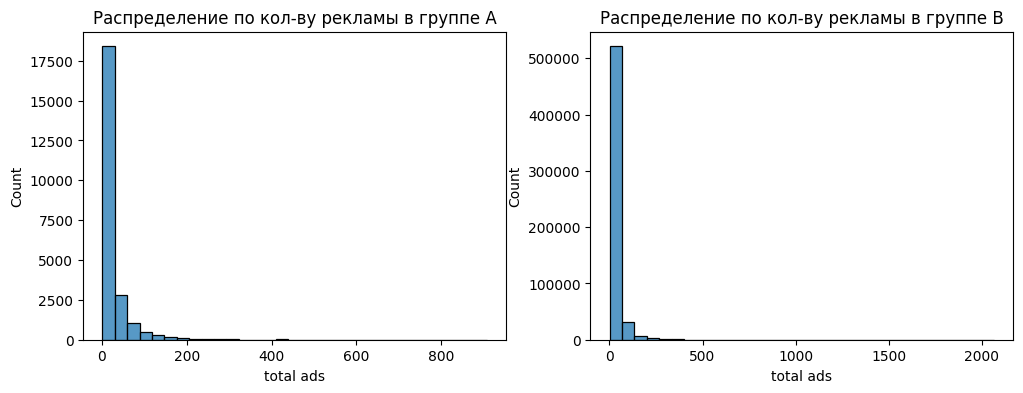

In [73]:
# создаём два графика размером
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для кол-ва показанной рекламы в каждой группе
sns.histplot(x='total ads', data=data[data['test group'] == 'psa'], bins=31, ax=axes[0])
sns.histplot(x='total ads', data=data[data['test group'] == 'ad'], bins=31, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение по кол-ву рекламы в группе А')
axes[1].set_title('Распределение по кол-ву рекламы в группе B');

Из графиков видно, что количество увиденной рекламы не имеет нормального распределения (похоже на логнормальное).

In [79]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(data[data['test group'] == 'psa']['total ads'])
shapiro_result_b = shapiro(data[data['test group'] == 'ad']['total ads'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального


/home/cavalier13/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [81]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=data[data['test group'] == 'psa']['total ads'],
    y=data[data['test group'] == 'ad']['total ads'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


С помощью аппарата статистических тестов определено: 
1) Существует статистически значимая разница в конверсиях между группами "ad" и "psa"
2) Существует статистически значимая разница в среднем количестве увиденной рекламы между группами "ad" и "psa"

### Доверительные интервалы

In [115]:
gamma = 0.95 # уровень надежности
alpha = 1 - gamma # уровень значимости

# Доверительные интервалы для конверсии
ci_conversion_a = proportion_confint(group_data.loc['psa', 'converted'],
                                     group_data.loc['psa', 'user_count'],
                                     alpha=alpha, method='wilson')
print('Доверительный интервал для конверсии в группе A:', 
      round(ci_conversion_a[0] * 100, 2),
      '-',
      round(ci_conversion_a[1] * 100, 2))

ci_conversion_b = proportion_confint(group_data.loc['ad', 'converted'],
                                     group_data.loc['ad', 'user_count'],
                                     alpha=alpha, method='wilson')
print('Доверительный интервал для конверсии в группе B:', 
      round(ci_conversion_b[0] * 100, 2),
      '-',
      round(ci_conversion_b[1] * 100, 2))

Доверительный интервал для конверсии в группе A: 1.62 - 1.96
Доверительный интервал для конверсии в группе B: 2.51 - 2.6


In [116]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound


# размеры выборок групп А и B
n = [group_data.loc['psa', 'user_count'], group_data.loc['ad', 'user_count']]
# выборочная пропорция групп A и B
#x_p = [group_data.loc['psa', 'conversion'], group_data.loc['ad', 'conversion']]
x_p = [group_data.loc['psa', 'conversion']/100, group_data.loc['ad', 'conversion']/100]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print(
    'Доверительный интервал для разности конверсий:', 
    round(lower_bound*100, 2),
    '-',
    round(upper_bound*100, 2)
)

Доверительный интервал для разности конверсий: 0.6 - 0.94


Истинная разница в конверсии положительная. Вариант '**B**' ('ad') более эффективен по метрике конверсии, чем вариант 'A' ('psa') с заданной надежностью 95%

In [117]:
# Доверительные интервалы для среднего количества увиденной рекламы
ci_ads_a = DescrStatsW(data[data['test group'] == 'psa']['total ads']).tconfint_mean(alpha=0.05)
print('Доверительный интервал для среднего количества увиденной рекламы в группе A:', 
      round(ci_ads_a[0], 2),
      '-',
      round(ci_ads_a[1], 2))


ci_ads_b = DescrStatsW(data[data['test group'] == 'ad']['total ads']).tconfint_mean(alpha=0.05)
print('Доверительный интервал для среднего количества увиденной рекламы в группе B:', 
      round(ci_ads_b[0], 2),
      '-',
      round(ci_ads_b[1], 2))

Доверительный интервал для среднего количества увиденной рекламы в группе A: 24.21 - 25.31
Доверительный интервал для среднего количества увиденной рекламы в группе B: 24.71 - 24.94


Доверительный интервал для среднего кол-ва рекламы группы B лежит внутри дов. интервала группы A. Это значит, различие в среднем количестве увиденной рекламы статистически не значимо.

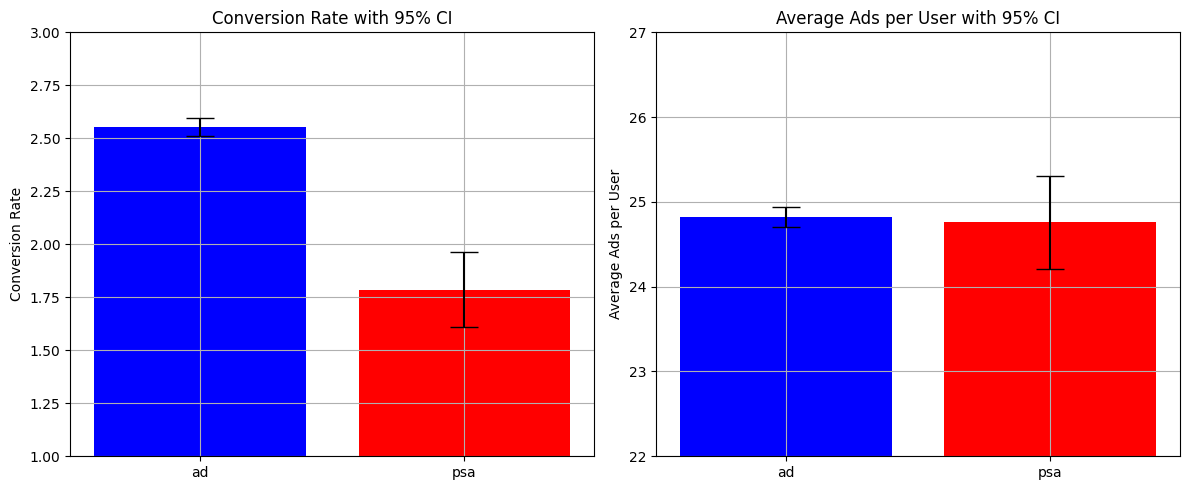

In [129]:
# Создание графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# График для конверсий
axes[0].bar(
    ['ad', 'psa'],
    [group_data.loc['ad', 'conversion'], group_data.loc['psa', 'conversion']], 
    yerr=[ci_conversion_b[1]*100 - group_data.loc['ad', 'conversion'], 
          ci_conversion_a[1]*100 - group_data.loc['psa', 'conversion']], 
    capsize=10, 
    color=['blue', 'red']
)
axes[0].grid()
axes[0].set_ylim([1, 3])
axes[0].set_ylabel('Conversion Rate')
axes[0].set_title('Conversion Rate with 95% CI')

# График для среднего количества увиденной рекламы
axes[1].bar(
    ['ad', 'psa'],
    [group_data.loc['ad', 'avg_ttl_ads'], group_data.loc['psa', 'avg_ttl_ads']], 
    yerr=[ci_ads_b[1] - group_data.loc['ad', 'avg_ttl_ads'], 
          ci_ads_a[1] - group_data.loc['psa', 'avg_ttl_ads']], 
    capsize=10, 
    color=['blue', 'red']
)
axes[1].grid()
axes[1].set_ylim([22, 27])
axes[1].set_ylabel('Average Ads per User')
axes[1].set_title('Average Ads per User with 95% CI')

# Отображение графиков
plt.tight_layout()
plt.show()

# Итоги

- Конверсия в группе "ad" (где пользователи видели рекламу) выше, чем в группе "psa" (где пользователи видели только объявление государственной службы). Это может указывать на положительное воздействие рекламной кампании на поведение пользователей.
- Статистический анализ подтверждает, что различие в конверсиях между группами "ad" и "psa" является статистически значимым. Это говорит о том, что рекламная кампания, скорее всего, влияет на поведение пользователей и способствует увеличению числа покупок.
- Доверительные интервалы для конверсий не пересекаются, что подчеркивает статистическую значимость различий в конверсиях между группами

На основе представленных данных и статистического анализа мы можем сделать вывод, что рекламная кампания оказывает положительное влияние на конверсию пользователей. Группа, которая видела рекламу, демонстрирует более высокую конверсию по сравнению с группой, которая видела только государственное объявление. Это подтверждается и статистическими тестами, и доверительными интервалами.

Однако, стоит также обратить внимание, что среднее количество увиденной рекламы практически одинаково в обеих группах. Это может указывать на эффективность рекламы.

Таким образом, успех рекламной кампании в значительной степени обоснован, и ее влияние на конверсию является статистически значимым.